<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Ensemble Learning. </center></h2>

In [20]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Read Data

In [21]:
df_X = pd.read_csv('./data/x_train.csv', sep=';')
df_y = pd.read_csv('./data/y_train.csv', sep=';', header=None, names=['target'])

In [22]:
X = df_X.values
y = df_y['target'].values

In [23]:
print("X shape: ", X.shape)
X[:5]

X shape:  (25289, 12)


array([[3.90000000e+01, 1.00000000e+01, 3.00000000e+00, 1.70000000e+01,
        2.44444444e+01, 1.00000000e+00, 5.00000000e+00, 4.00000000e-01,
        2.65000000e+06, 1.37500000e+03, 2.10000000e+01, 2.00000000e+00],
       [2.10000000e+01, 2.20000000e+01, 1.90000000e+01, 5.50000000e+01,
        1.70454545e+01, 1.00000000e+00, 6.00000000e+00, 3.33333333e-01,
        5.61400000e+06, 3.82500000e+03, 5.10000000e+01, 4.00000000e+00],
       [5.00000000e+00, 6.00000000e+00, 1.00000000e+00, 6.00000000e+00,
        8.40000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        8.57000000e+05, 1.15000000e+03, 1.40000000e+01, 1.00000000e+00],
       [2.10000000e+01, 2.00000000e+00, 5.00000000e+00, 6.00000000e+00,
        1.90000000e+01, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.20000000e+05, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.00000000e+00, 5.00000000e+00, 1.00000000e+00, 5.00000000e+00,
        9.60000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00

In [24]:
print("y shape: ", y.shape)
y[:5]

y shape:  (25289,)


array([0, 1, 1, 1, 0])

# Train / Test Split

In [25]:
# import train_test_split function to split the sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5,    
                                                    random_state=123) 

# Task 1 (5 points)

Implement Random Forest classifier as it was described in your lectures:

**Input**: 
* training dataset $TDS=\{(x_{i},y_{i}),\,1=1,2,...N\}$; 
* the number of trees $B$ and the size of feature subsets $m$.

for $b=1,2,...B$:

1. generate random training dataset $TDS^{b}$ of size $N$ by sampling $(x_{i},y_{i})$ pairs from $TDS$ with replacement (bootstrap)
2. build a tree using $TDS^{b}$ training dataset with feature selection for each node from random subset of features of size $m$ (generated **individually for each node**).


**Output**: $B$ trees. Classification is done using majority vote and regression using averaging of $B$ outputs

**Hints:**
- Use decision tree classifier from sklean library. You can import it with the command: `from sklearn.tree import DecisionTreeClassifier` with `max_features` option. 
- You can use `numpy.random.choice()` function to generate random subsamples to train decition tree classifiers.

### Let' s start with small steps

#### First step

Implement auxiliary function, which generate K random subsamples (with replacement) of X, y of size N

In [26]:
def gen_subsamples(X, y, K, N):
    list = []
    Xy_data = np.column_stack((X,y))
    
    for i in range(K):
        idx = np.random.choice(a=range(len(X)), size=N, replace=True)
        list.append(Xy_data[idx])
        
    return list

#### Second step

Implement auxiliary function which get list of (X,y) with lengh K and fit K base_estimators. Each estimator fit from the corresponding sample. 

In [27]:
def fit_subsamples(subsamples, base_estimator):
    for i in range(np.shape(subsamples)[0]):
        x_array = subsamples[i][:, 0:12]
        y_array = subsamples[i][:, 12]
        base_estimator(x_array, y_array)

#### Example with multiprocessing

In [28]:
from sklearn.tree import DecisionTreeClassifier

def fit(params):
    X, y, size = params
    subsamples = gen_subsamples(X, y, size, X.shape[0])

    return fit_subsamples(subsamples, DecisionTreeClassifier)


In [29]:
import multiprocessing

process_count = 4

parts = [
    (X, y, 1000 // process_count)
    for i in range(process_count)
]

In [31]:
with multiprocessing.Pool(process_count) as p:
    clfs = p.map(fit, parts)

### And now combine it all together in one class

In [32]:
class RandomForestCalssifier(object):
    def __init__(self, n_trees=10, n_subset_features=2):
        self.n_trees = n_trees
        self.n_subset_features = n_subset_features
        self.tlist = []

    def fit(self, X, y):
        for i in range(self.n_trees):
            idx = np.random.choice(a=range(len(X)), size=len(X), replace=True)

            x_array = X[idx]
            y_array = y[idx]

            tree_classifier = DecisionTreeClassifier()
            tree_classifier.fit(x_array, y_array)

            self.tlist.append(tree_classifier)


    def predict_proba(self, X):
        prob_array = []

        for i in range(self.n_trees):
            try:
                prob_array.append(self.tlist[i].predict_proba(X))
            except:
                continue

        prob_array = np.array(prob_array)
        mean = prob_array.mean(axis=0)
        
        return mean


    def predict(self, X):
        pred_array = []

        for i in range(self.n_trees):
            pred_array.append(self.tlist[i].predict(X))

        pred_array = np.array(pred_array)
        result = 1. * (pred_array.mean(axis=0) >= 0.5)

        return result


In [33]:
clf = RandomForestCalssifier()
clf.fit(X_train, y_train)

In [34]:
y_test_predict = clf.predict(X_test)
y_test_predict[:10]

array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])

# Task 2 (1 point)

Plot ROC curve on the test sample for your random forest classifier. Also, claculate ROC AUC value. Use `RandomForestClassifier.predict_proba()` method.

Hints:
- You can use `sklearn.metrics.roc_curve` frunction to calculate ROC curve.
- `sklearn.metrics.roc_auc_score` function helps you to calculate ROC AUC value.

In [35]:
from sklearn import metrics

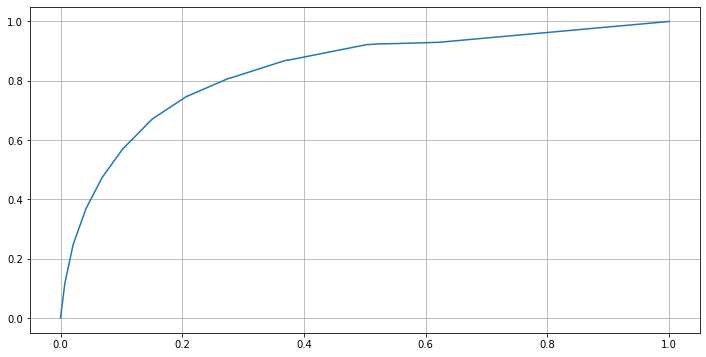

In [36]:
y_test_prob = clf.predict_proba(X_test)
line1, line2, notneed = metrics.roc_curve(y_test, y_test_prob[:, 1])

plt.figure(figsize=(12, 6))
plt.plot(line1, line2)
plt.grid()
plt.show()

In [37]:
score = metrics.roc_auc_score(y_test, y_test_predict)
print('ROC AUC Score: ' + str(score))

ROC AUC Score: 0.7602887849667125


# Task 3 (2 points)

Plot dependecy of ROC AUC value from number of trees (`n_trees`) in your random forest classifier.

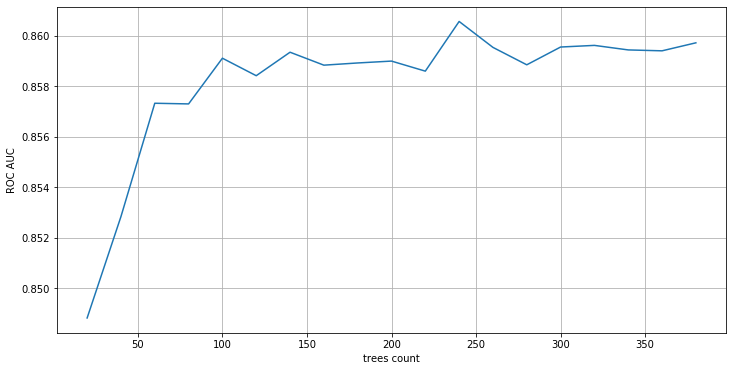

In [38]:
ROCAUC = []

n_trees = np.arange(20, 400, 20)
tree_size = len(n_trees)

for i in range(tree_size):
    clf = RandomForestCalssifier(n_trees=n_trees[i], n_subset_features=2)
    clf.fit(X_train, y_train)
    
    prob_array = clf.predict_proba(X_test)
    ROCAUC.append(metrics.roc_auc_score(y_test, prob_array[:, 1]))
    
plt.figure(figsize=(12, 6))
plt.xlabel("trees count")
plt.ylabel("ROC AUC")
plt.plot(n_trees, ROCAUC)
plt.grid()
plt.show()

# Task 4 (2 points)

Plot dependecy of ROC AUC value from `n_subset_features` of your random forest classifier. Use `n_trees=100`.

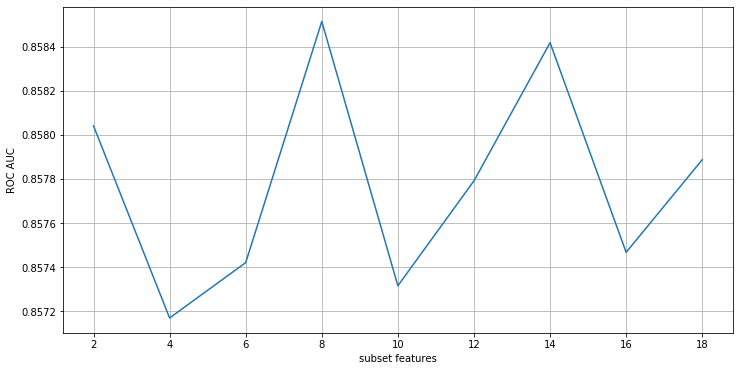

In [40]:
ROCAUC = []

n_subset_features = np.arange(2,20,2)
subset_size = len(n_subset_features)

for i in range(subset_size):
    clf = RandomForestCalssifier(n_trees=100, n_subset_features=n_trees[i])
    clf.fit(X_train, y_train)
    
    prob_array = clf.predict_proba(X_test)
    ROCAUC.append(metrics.roc_auc_score(y_test, prob_array[:, 1]))
    
plt.figure(figsize=(12, 6))
plt.xlabel("subset features")
plt.ylabel("ROC AUC")
plt.plot(n_subset_features, ROCAUC)
plt.grid()
plt.show()